In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plot
import seaborn as sbn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from lime.lime_tabular import LimeTabularExplainer
import warnings
warnings.filterwarnings("ignore")

# Obtendo dataframe do dataset diamond.csv
df = pd.read_csv("https://raw.githubusercontent.com/cassiusf/datasets/main/diamonds.csv")

# aplicando o variable dummies as features 'color' e 'clarity' e integrando-as no dataset.
color_dummies = pd.get_dummies(df['color'])
clarity_dummies = pd.get_dummies(df['clarity'])
df = pd.concat([df.drop(columns=['color', 'clarity']), color_dummies, clarity_dummies], axis=1)

# Visualizando a distribuição de targets do dataset
df['cut'].value_counts()

cut
Ideal      21551
Premium    13791
Name: count, dtype: int64

In [14]:
def classificacao(valor):
    if (valor == 'Ideal'):
        return 0 
    elif valor == 'Premium':
        return 1 
    elif valor == 'Very Good':
        return 3
    elif valor =='Good':
        return 4
    else: 
        return 5

# codificação do target
df['cut'] = df['cut'].apply(classificacao)

# Separando as variáveis dependentes das independentes
df_independentes = df.drop(columns=['depth', 'table'])
df_dependentes = df[['depth', 'table']]

# Aplicando Standard Scale no conjunto de dados
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_independentes)

X_treino, X_teste, y_treino, y_teste = train_test_split(df_independentes.drop(columns='cut'), df['cut'], test_size=0.25, random_state=7)

### 1. Matriz de Confusão da Árvore de decisão Padrão

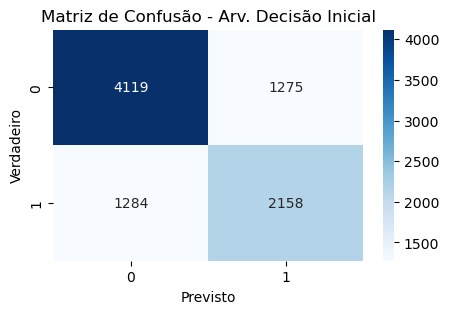

In [15]:
# Treinamento do modelo Árvore de decisão
modelo_inicial = DecisionTreeClassifier().fit(X_treino, y_treino)
y_predito = modelo_inicial.predict(X_teste)
modelo_inicial_cm = confusion_matrix(y_teste, y_predito)

# Plot Matriz de Confusão
fig = plot.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sbn.heatmap(modelo_inicial_cm, cmap='Blues',annot=True, ax=ax, fmt='d')
plot.title('Matriz de Confusão - Arv. Decisão Inicial')
ax.set_ylabel('Verdadeiro')
ax.set_xlabel('Previsto')
plot.show()

### 2. Relatório de classificação (Scores)

In [16]:
# Avaliação do modelo inicial
print(f"Acurácia: {accuracy_score(y_teste, y_predito)}")
print(f"Precisão: {precision_score(y_teste, y_predito, average='macro')}")
print(f"Recall: {recall_score(y_teste, y_predito, average='macro')}")
print(f"F1-Score: {f1_score(y_teste, y_predito, average='macro')}")

Acurácia: 0.710389316432775
Precisão: 0.695479483272474
Recall: 0.6952936602681397
F1-Score: 0.6953857687741545


### 3. Classificação com RandomForest Padrão

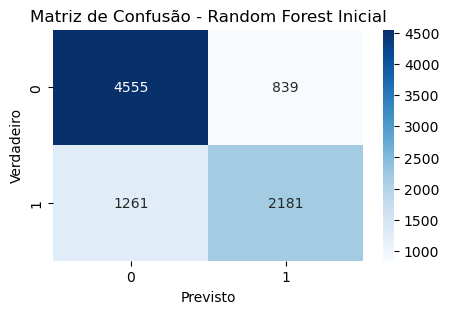

Acurácia: 0.7623358985966501
Precisão: 0.752684874791623
Recall: 0.7390500172679868
F1-Score: 0.7438452370007214


In [17]:
# Classificação com RandomForest Padrão
modelo_rf = RandomForestClassifier().fit(X_treino, y_treino)
y_predito_rf = modelo_rf.predict(X_teste)
modelo_rf_cm = confusion_matrix(y_teste, y_predito_rf)

# Plot Matriz de Confusão
fig = plot.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sbn.heatmap(modelo_rf_cm, cmap='Blues',annot=True, ax=ax, fmt='d')
plot.title('Matriz de Confusão - Random Forest Inicial')
ax.set_ylabel('Verdadeiro')
ax.set_xlabel('Previsto')
plot.show()

# Avaliação do modelo RandomForest
print(f"Acurácia: {accuracy_score(y_teste, y_predito_rf)}")
print(f"Precisão: {precision_score(y_teste, y_predito_rf, average='macro')}")
print(f"Recall: {recall_score(y_teste, y_predito_rf, average='macro')}")
print(f"F1-Score: {f1_score(y_teste, y_predito_rf, average='macro')}")

### 4. e 5. GridSearch de RandomForest e Avaliações dos modelos

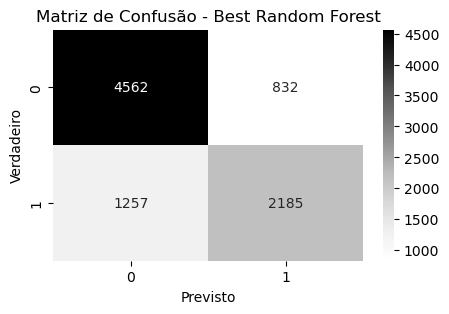

Acurácia: 0.7635808057944772
Precisão: 0.7541064346203843
Recall: 0.740279943906512
F1-Score: 0.7451368535296772


In [18]:
# GridSearch de RandomForest e Avaliações dos modelos
parametros = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


grid_search = GridSearchCV(
    estimator=RandomForestClassifier(), 
    param_grid=parametros, 
    cv=5,
    scoring='accuracy', 
    refit=True
)
grid_search.fit(X_treino, y_treino)
y_predito_best_rf = grid_search.predict(X_teste)
best_rf_cm = confusion_matrix(y_teste, y_predito_best_rf)

# Plot Matriz de Confusão
fig = plot.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sbn.heatmap(best_rf_cm, cmap='Grays',annot=True, ax=ax, fmt='d')
plot.title('Matriz de Confusão - Best Random Forest')
ax.set_ylabel('Verdadeiro')
ax.set_xlabel('Previsto')
plot.show()

# Avaliação do modelo RandomForest
print(f"Acurácia: {accuracy_score(y_teste, y_predito_best_rf)}")
print(f"Precisão: {precision_score(y_teste, y_predito_best_rf, average='macro')}")
print(f"Recall: {recall_score(y_teste, y_predito_best_rf, average='macro')}")
print(f"F1-Score: {f1_score(y_teste, y_predito_best_rf, average='macro')}")

### 6. Classificando com XGBoost

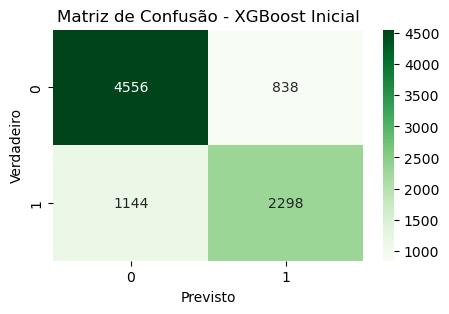

Acurácia: 0.775690357627886
Precisão: 0.7660394289294665
Recall: 0.756138645453004
F1-Score: 0.7600187414187931


In [19]:
# Classificação com XGBoost
modelo_xgb = XGBClassifier().fit(X_treino, y_treino)
y_predito_xgb = modelo_xgb.predict(X_teste)
modelo_xgb_cm = confusion_matrix(y_teste, y_predito_xgb)

# Plot Matriz de Confusão
fig = plot.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sbn.heatmap(modelo_xgb_cm, cmap='Greens',annot=True, ax=ax, fmt='d')
plot.title('Matriz de Confusão - XGBoost Inicial')
ax.set_ylabel('Verdadeiro')
ax.set_xlabel('Previsto')
plot.show()

# Avaliação do modelo XGBoost
print(f"Acurácia: {accuracy_score(y_teste, y_predito_xgb)}")
print(f"Precisão: {precision_score(y_teste, y_predito_xgb, average='macro')}")
print(f"Recall: {recall_score(y_teste, y_predito_xgb, average='macro')}")
print(f"F1-Score: {f1_score(y_teste, y_predito_xgb, average='macro')}")

### 7.Classificando com SVM

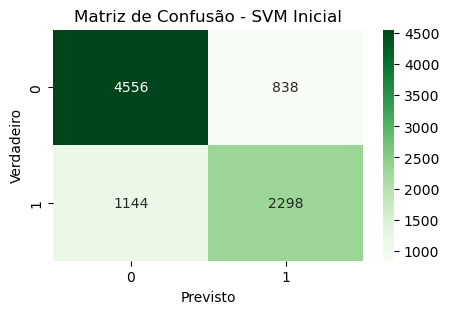

Acurácia: 0.6129470348574015
Precisão: 0.5696952102938766
Recall: 0.5167585651046195
F1-Score: 0.44546131181763327


In [20]:
# Classificação com SVM
modelo_svc = SVC().fit(X_treino, y_treino)
y_predito_svc = modelo_svc.predict(X_teste)
modelo_svc_cm = confusion_matrix(y_teste, y_predito_xgb)

# Plot Matriz de Confusão
fig = plot.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sbn.heatmap(modelo_svc_cm, cmap='Greens',annot=True, ax=ax, fmt='d')
plot.title('Matriz de Confusão - SVM Inicial')
ax.set_ylabel('Verdadeiro')
ax.set_xlabel('Previsto')
plot.show()

# Avaliação do modelo SVM
print(f"Acurácia: {accuracy_score(y_teste, y_predito_svc)}")
print(f"Precisão: {precision_score(y_teste, y_predito_svc, average='macro')}")
print(f"Recall: {recall_score(y_teste, y_predito_svc, average='macro')}")
print(f"F1-Score: {f1_score(y_teste, y_predito_svc, average='macro')}")

### 8. 9. 10. Gridsearch com SVM e Avaliações

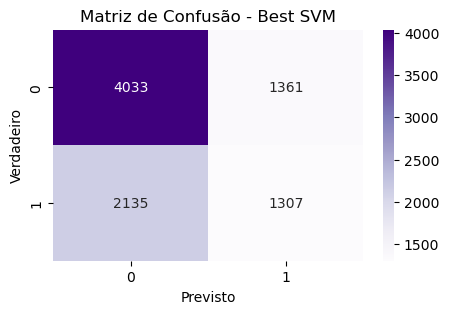

Acurácia: 0.6043458578542327
Precisão: 0.571869342566071
Recall: 0.5637018513479479
F1-Score: 0.5627267041901188


In [21]:
# GridSearch de SVM e Avaliações dos modelos
parametros_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'sigmoid']
}

grid_search_svc = GridSearchCV(
    estimator=SVC(max_iter=10000),
    param_grid=parametros_svc,
    scoring='accuracy'
)

grid_search_svc.fit(X_treino, y_treino)
y_predito_best_svc = grid_search_svc.best_estimator_.predict(X_teste)
best_svc_cm = confusion_matrix(y_teste, y_predito_best_svc)

# Plot Matriz de Confusão
fig = plot.figure(figsize=(5,3))
ax = fig.add_subplot(111)
sbn.heatmap(best_svc_cm, cmap='Purples',annot=True, ax=ax, fmt='d')
plot.title('Matriz de Confusão - Best SVM')
ax.set_ylabel('Verdadeiro')
ax.set_xlabel('Previsto')
plot.show()

# Avaliação do modelo SVM
print(f"Acurácia: {accuracy_score(y_teste, y_predito_best_svc)}")
print(f"Precisão: {precision_score(y_teste, y_predito_best_svc, average='macro')}")
print(f"Recall: {recall_score(y_teste, y_predito_best_svc, average='macro')}")
print(f"F1-Score: {f1_score(y_teste, y_predito_best_svc, average='macro')}")

### 11. e 12. Analisar a importância das Features no melhor modelo Random Forest

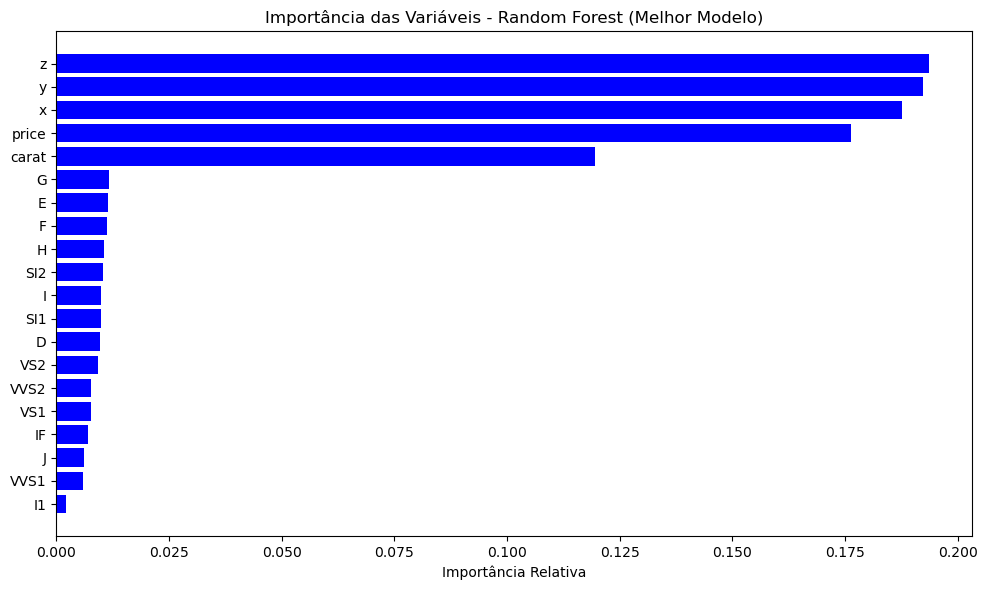

In [22]:
# Extrair importância das variáveis
feature_importance = grid_search.best_estimator_.feature_importances_
features = X_teste.columns
indices = np.argsort(feature_importance)[::-1]

# Criar gráfico de importância
plot.figure(figsize=(10, 6))
plot.title("Importância das Variáveis - Random Forest (Melhor Modelo)")
plot.barh(range(len(indices)), feature_importance[indices], color='b', align='center')
plot.yticks(range(len(indices)), [features[i] for i in indices])
plot.xlabel("Importância Relativa")
plot.gca().invert_yaxis()  # Exibir a feature mais importante no topo
plot.tight_layout()
plot.show()

### 13. e 14. Usando Lime no melhor modelo Random Forest

Explicação para a instância 7:
Explicação para a instância 42:


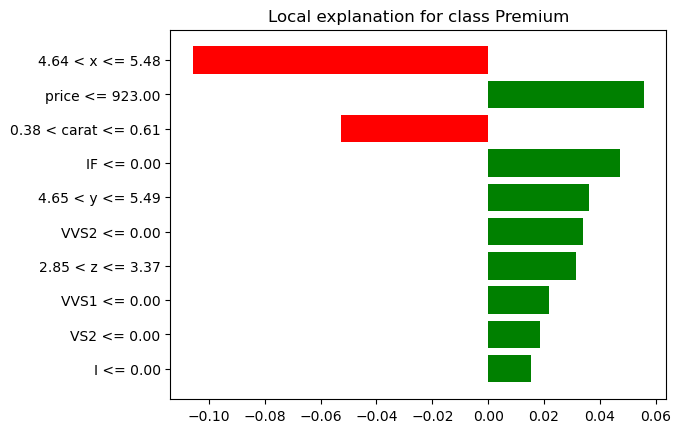

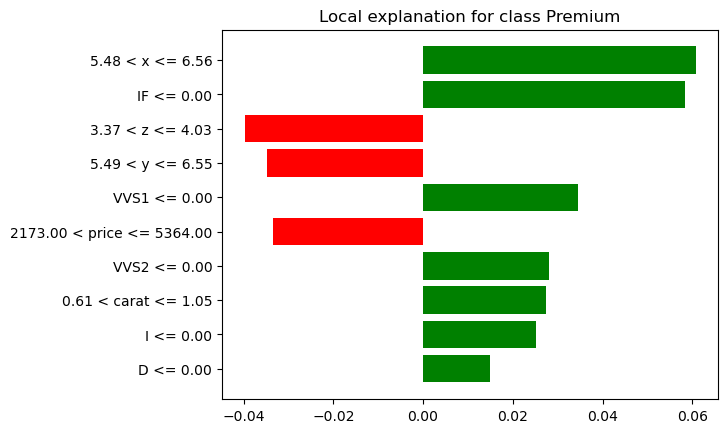

In [23]:
explainer = LimeTabularExplainer(
    training_data=np.array(X_treino),
    feature_names=X_treino.columns,
    class_names=['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'],
    mode='classification'
)

# Explicação de uma previsão específica
for i in [7,42]:
    explicacao = explainer.explain_instance(
        data_row=X_teste.iloc[i],
        predict_fn=grid_search.predict_proba
    )
    print(f"Explicação para a instância {i}:")
    explicacao.as_pyplot_figure()

